In [2]:
#Feature Engineering
#Creating dummy variables and building the models- KNN, logistic regression, SVM, random forest
#Ensemble methods
#Accuracy testing using ROC curve and plotting learning curve


import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder # For change categorical variable into int
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV 

sm = SMOTE(random_state=42)
convert_data_no_dummy = LabelEncoder()
from sklearn import svm
convert_data = LabelEncoder()
scaler = preprocessing.StandardScaler() 

In [3]:
#read data from file 
data = pd.read_csv(r'C:/Users/*/HR_comma_sep.csv') #read data from csv

#data getting dummy
dummies_time_spend = pd.get_dummies(data['time_spend_company'], prefix= 'time_spend_company')
dummies_Project = pd.get_dummies(data['number_project'], prefix= 'number_project')
dummies_Working_accident = pd.get_dummies(data['Work_accident'], prefix= 'Work_accident')
dummies_Promotion = pd.get_dummies(data['promotion_last_5years'], prefix= 'promotion_last_5years')
dummies_Sales = pd.get_dummies(data['sales'], prefix= 'sales')
dummies_Salary = pd.get_dummies(data['salary'], prefix= 'salary')

In [5]:
#normalize the average montly hours because it range from 100-300 it don't it will domain other variables
age_scale_param = scaler.fit(pd.DataFrame(data['average_montly_hours']))
data['average_montly_hours'] = scaler.fit_transform(pd.DataFrame(data['average_montly_hours']), age_scale_param)

#join the dummy variables with the original dataset and eliminate the original attributes
data = pd.concat([data,dummies_Project, dummies_Promotion,dummies_Salary, dummies_Sales, dummies_time_spend, dummies_Working_accident],axis = 1)
data.drop(['number_project', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales', 'salary'], axis=1, inplace=True)


In [6]:
#calculate the correlation of the variables, some variables have strong correlation that cannot used to build the model
variables_corr = data.corr()
plt.figure(figsize=(20,30))
sns.heatmap(variables_corr,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=90)
#some strong correlation between variables were found and we need to drop those variables whose correlation is >= 0.5, only drop one of them
data.drop(['promotion_last_5years_0', 'salary_low', 'Work_accident_0'], axis = 1, inplace = True)
#plot the correlation again to see whether they still have strong relationship
variables_corr_cut = data.corr()
plt.figure(figsize=(20,30))
sns.heatmap(variables_corr_cut,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=90)
name_of_variables = list(data)
#remode the name of 'left'
name_of_variables.remove('left')
#transfer the pd.dataframe to numpy array for easy calculation
data = data.as_matrix()

In [9]:
#separate the target variable and predicators
y = data[:, 0]
x = data[:, 1:]

#oversampling the data
x, y = sm.fit_sample(x, y)
#seperate the training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.3,random_state=0)
#------------------------------ gridsearch function to find the best parameter setting
def finding_best_parameters(model, X_train, y_train, params):
    clf = GridSearchCV(model,params,scoring="accuracy",cv=5)
    clf.fit(X_train,y_train)
    
    return clf

In [10]:
#default parameter to build the logistic regression model
lin_regression = linear_model.LogisticRegression()
score_linear_dummy = cross_val_score(lin_regression, X_train, y_train, cv = 10)
#use the model to predict the samples
yhat_linear = lin_regression.fit(X_train, y_train).predict(X_test)
#calculate the accuracy of test set
linear_accuracy = accuracy_score(yhat_linear, y_test)  

#train the random forest classifier
random_classify = RandomForestClassifier()
#the accuracy in 10 fold cross validation
score_RF = cross_val_score(random_classify, X_train, y_train, cv = 10)
#RF's accuracy in test set
yhat_randomForest = random_classify.fit(X_train, y_train).predict(X_test)
randomForest_acc = accuracy_score(yhat_randomForest, y_test)

#run svm algorithm
svm_classifier = svm.SVC()
score_svm =cross_val_score(svm_classifier, X_train, y_train, cv = 10)
yhat_svm = svm_classifier.fit(X_train, y_train).predict(X_test)
svm_acc = accuracy_score(yhat_svm, y_test)

#run knn algorithm
knn_classifier = knn()
score_knn =cross_val_score(knn_classifier, X_train, y_train, cv = 10)
yhat_knn = knn_classifier.fit(X_train, y_train).predict(X_test)
knn_acc = accuracy_score(yhat_knn, y_test)

In [11]:
#store the accuracy in cross validation and testset in pd.dataframe
Accuracy_dummy = pd.DataFrame(
    { "Accuracy with dummy:":[score_linear_dummy.mean(), score_knn.mean(), score_RF.mean(), score_svm.mean() ],
"Classification Algorithms" :['LogisticRegression', 'KNN', 'Random Forest', 'SVM']

    })

Accuracy_dummy.head()

,Accuracy with dummy:,Classification Algorithms
0,0.907720,LogisticRegression
1,0.942258,KNN
2,0.981951,Random Forest
3,0.929441,SVM


In [12]:
Accuracy_dummy.describe()

,Accuracy with dummy:
count,4.000000
mean,0.940342
std,0.031188
min,0.907720
25%,0.924011
50%,0.935850
75%,0.952181
max,0.981951


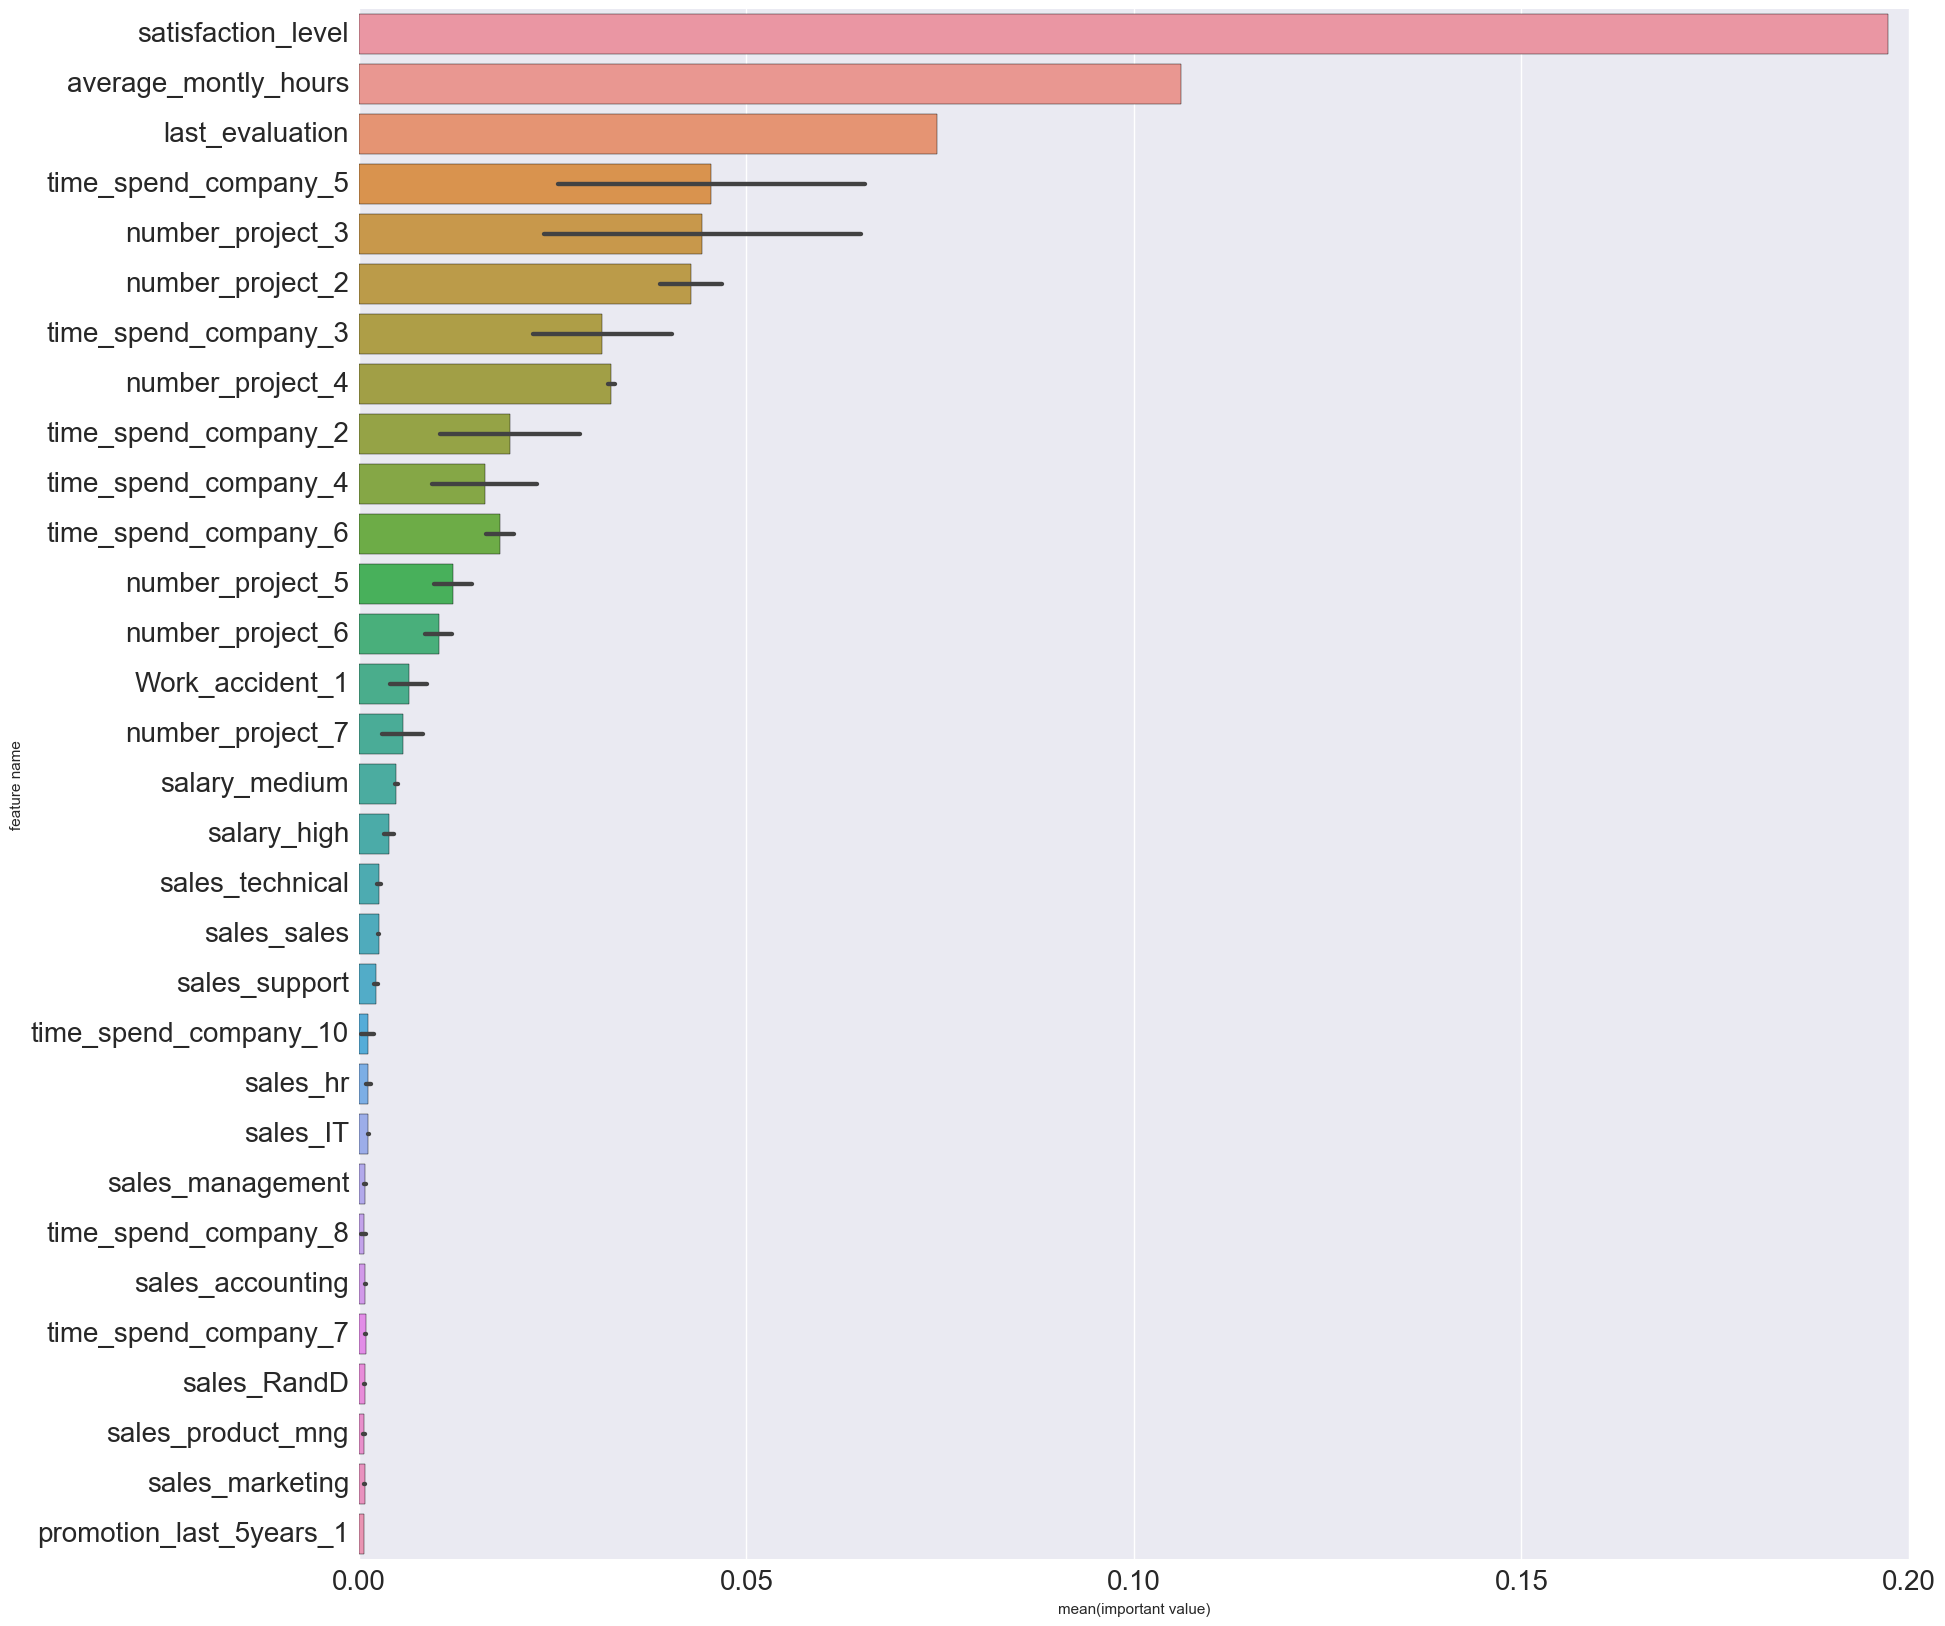

In [15]:
#find the important features from random forest model
importance_features_values = random_classify.feature_importances_
importance_values = zip(name_of_variables, importance_features_values)
#sort the importance values by descending order
importance_values = sorted(importance_values, key=lambda values: values[1])
importance_values.reverse()
importance_features_values = list(importance_features_values)
fea_import = pd.DataFrame(
    { "feature name":[i[0] for i in importance_values ],
"important value" :[i[1] for i in importance_values ]

    })
    

#plot important features
plt.figure(figsize=(20,20))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
ax = sns.barplot(y = "feature name", x = "important value", data = fea_import)

plt.show()

In [16]:
#index of the 15 most important features
index_of_8important = []
for i in range(15):
    index_of_8important.append(importance_features_values.index(importance_values[i][1]))
x = x[:,index_of_8important]                                



#split the dataset as training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2,
                                                    random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.3,
                                                    random_state=0)
#use grid search to find the best parameters for each model
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1', 'l2']}
model = linear_model.LogisticRegression()
lin_regression_cut = finding_best_parameters(model, X_train, y_train, params)
#use the model to predict the samples
yhat_linear_cut = lin_regression_cut.predict(X_test)
#calculate the accuracy of test set
linear_accuracy_cut = accuracy_score(yhat_linear_cut, y_test)  
#train the random forest classifier
params = {'n_estimators':(70,80,90,100),'criterion':('gini','entropy'),'max_depth':[25,30]}
model = RandomForestClassifier()
random_classify_cut = finding_best_parameters(model, X_train, y_train, params)
yhat_randomForest_cut = random_classify_cut.predict(X_test)
randomForest_acc_cut = accuracy_score(yhat_randomForest_cut, y_test)


In [17]:
#run svm algorithm
params = {'kernel': ['linear', 'poly', 'sigmoid'], 'C': [100, 1000] }
model = svm.SVC()
svm_classifier_cut = finding_best_parameters(model, X_validation, y_validation, params)
yhat_svm_cut = svm_classifier_cut.predict(X_test)
svm_acc_cut = accuracy_score(yhat_svm_cut, y_test)

#run knn algorithm
params = [{'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 20]}]
model = knn()
knn_classifier_cut = finding_best_parameters(model, X_train, y_train, params)
yhat_knn_cut = knn_classifier_cut.predict(X_test)
knn_acc_cut = accuracy_score(yhat_knn_cut, y_test)

#store the accuracy and the best parameters from gridsearch            
Accuracy_dummy_import_feature = pd.DataFrame(
    { "Accuracy with dummy and important features:":[lin_regression_cut.best_score_, knn_classifier_cut.best_score_, random_classify_cut.best_score_, svm_classifier_cut.best_score_ ],
"Classification Algorithms" :['LogisticRegression', 'KNN', 'Random Forest', 'SVM'],
"best parameter": [str(lin_regression_cut.best_params_), str(knn_classifier_cut.best_params_), str(random_classify_cut.best_params_),str(svm_classifier_cut.best_params_)]})


fpr = dict()
tpr = dict()
roc_auc = dict()
auc_val = dict()

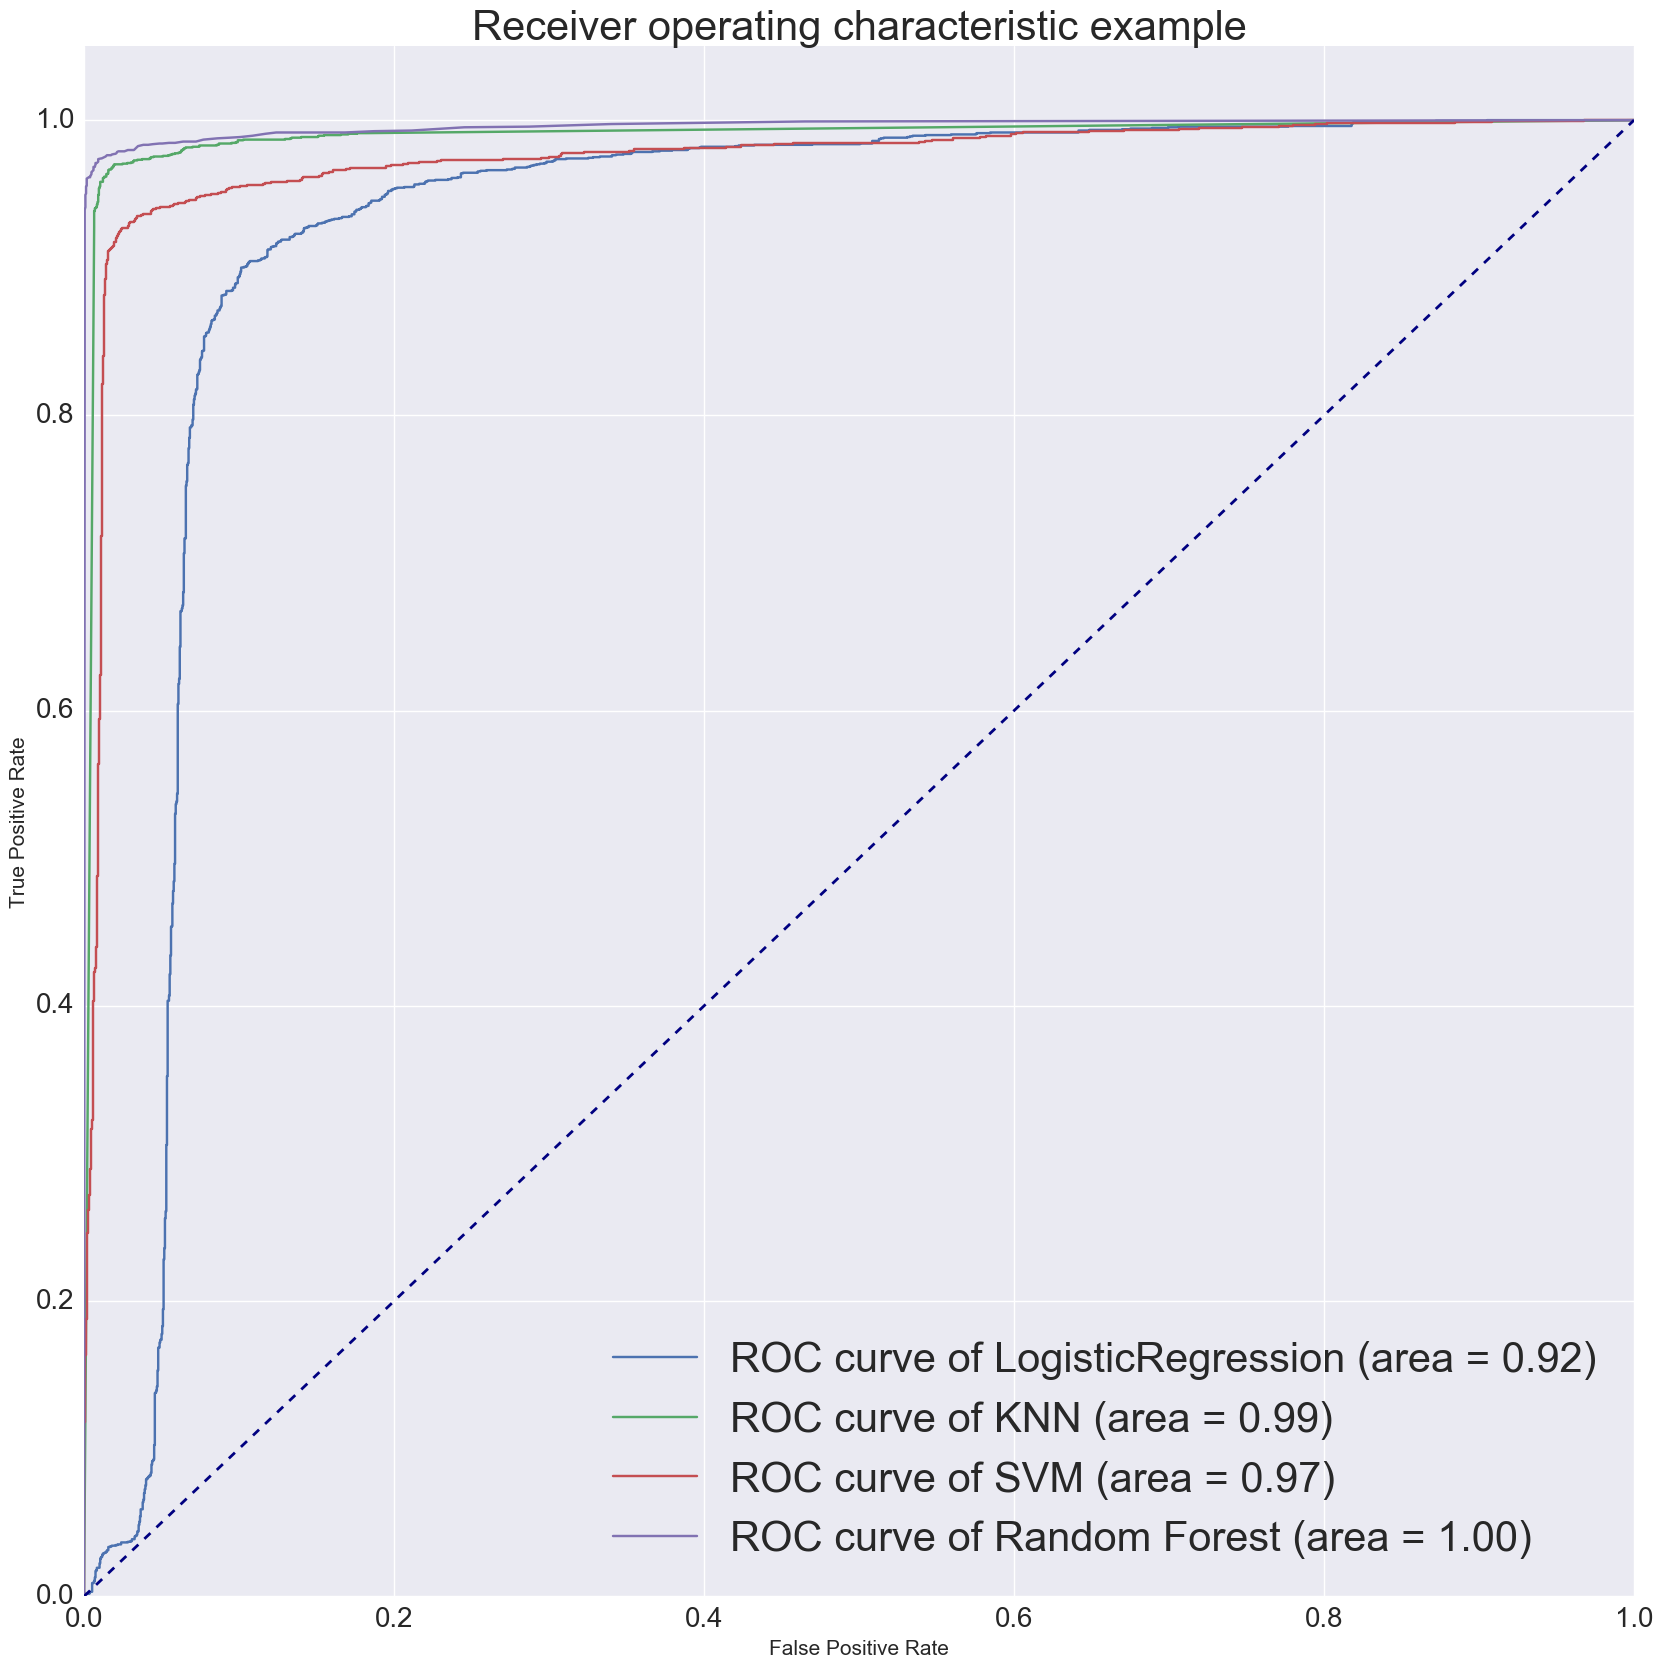

In [18]:
#plot the roc curve
y_score_linear = linear_model.LogisticRegression(C = 1000, penalty = 'l1').fit(X_train, y_train).decision_function(X_test)
y_score_knn =  knn(n_neighbors=10, weights = 'distance').fit(X_train, y_train).predict_proba(X_test)
y_score_knn = y_score_knn[:, 1]
y_score_svm = svm.SVC(C = 1000, kernel = 'poly').fit(X_train, y_train).decision_function(X_test)
y_score_RF = RandomForestClassifier(criterion =  'gini', max_depth =  30, n_estimators =  100).fit(X_train, y_train).predict_proba(X_test)
y_score_RF = y_score_RF[:, 1]
y_score = [y_score_linear, y_score_knn, y_score_svm, y_score_RF]
classifier_name = ['LogisticRegression', 'KNN', 'SVM', 'Random Forest']
#calculate auc value
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_val[i] = metrics.auc(fpr[i], tpr[i])
    
#plot roc curve
plt.figure(figsize=(20, 20))
lw = 2
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'
                                   ''.format(classifier_name[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.rc('legend', fontsize=30)    # legend fontsize
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('Receiver operating characteristic example', fontsize = 30)
plt.legend(loc="lower right")
plt.show()


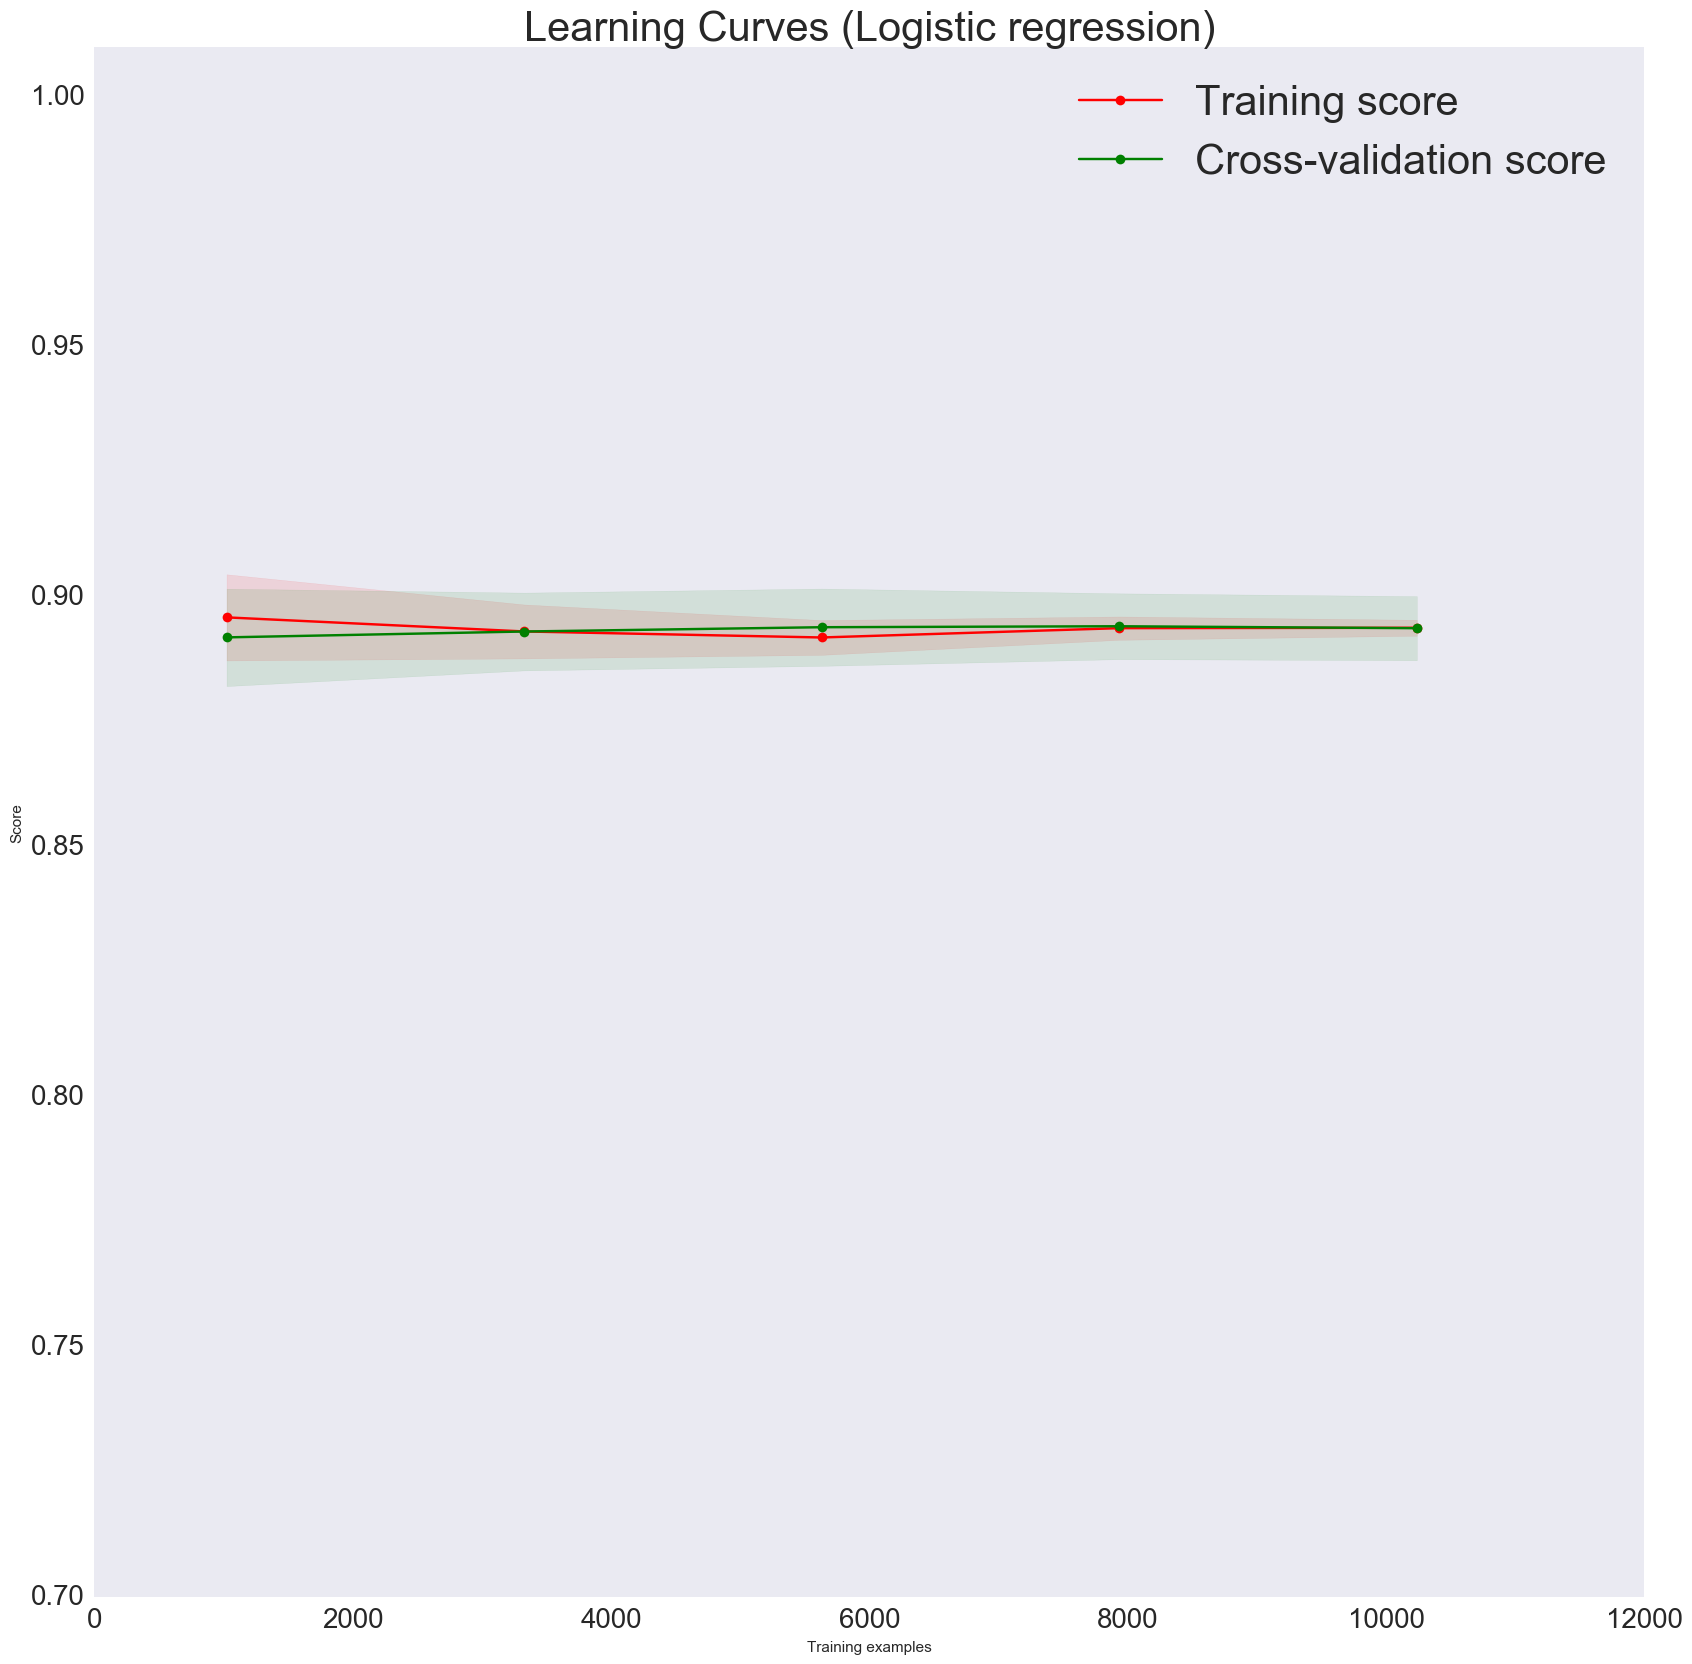

In [20]:
#plot the learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(20, 20))
    plt.title(title, fontsize = 30)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = linear_model.LogisticRegression(C = 1000, penalty = 'l1')
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()


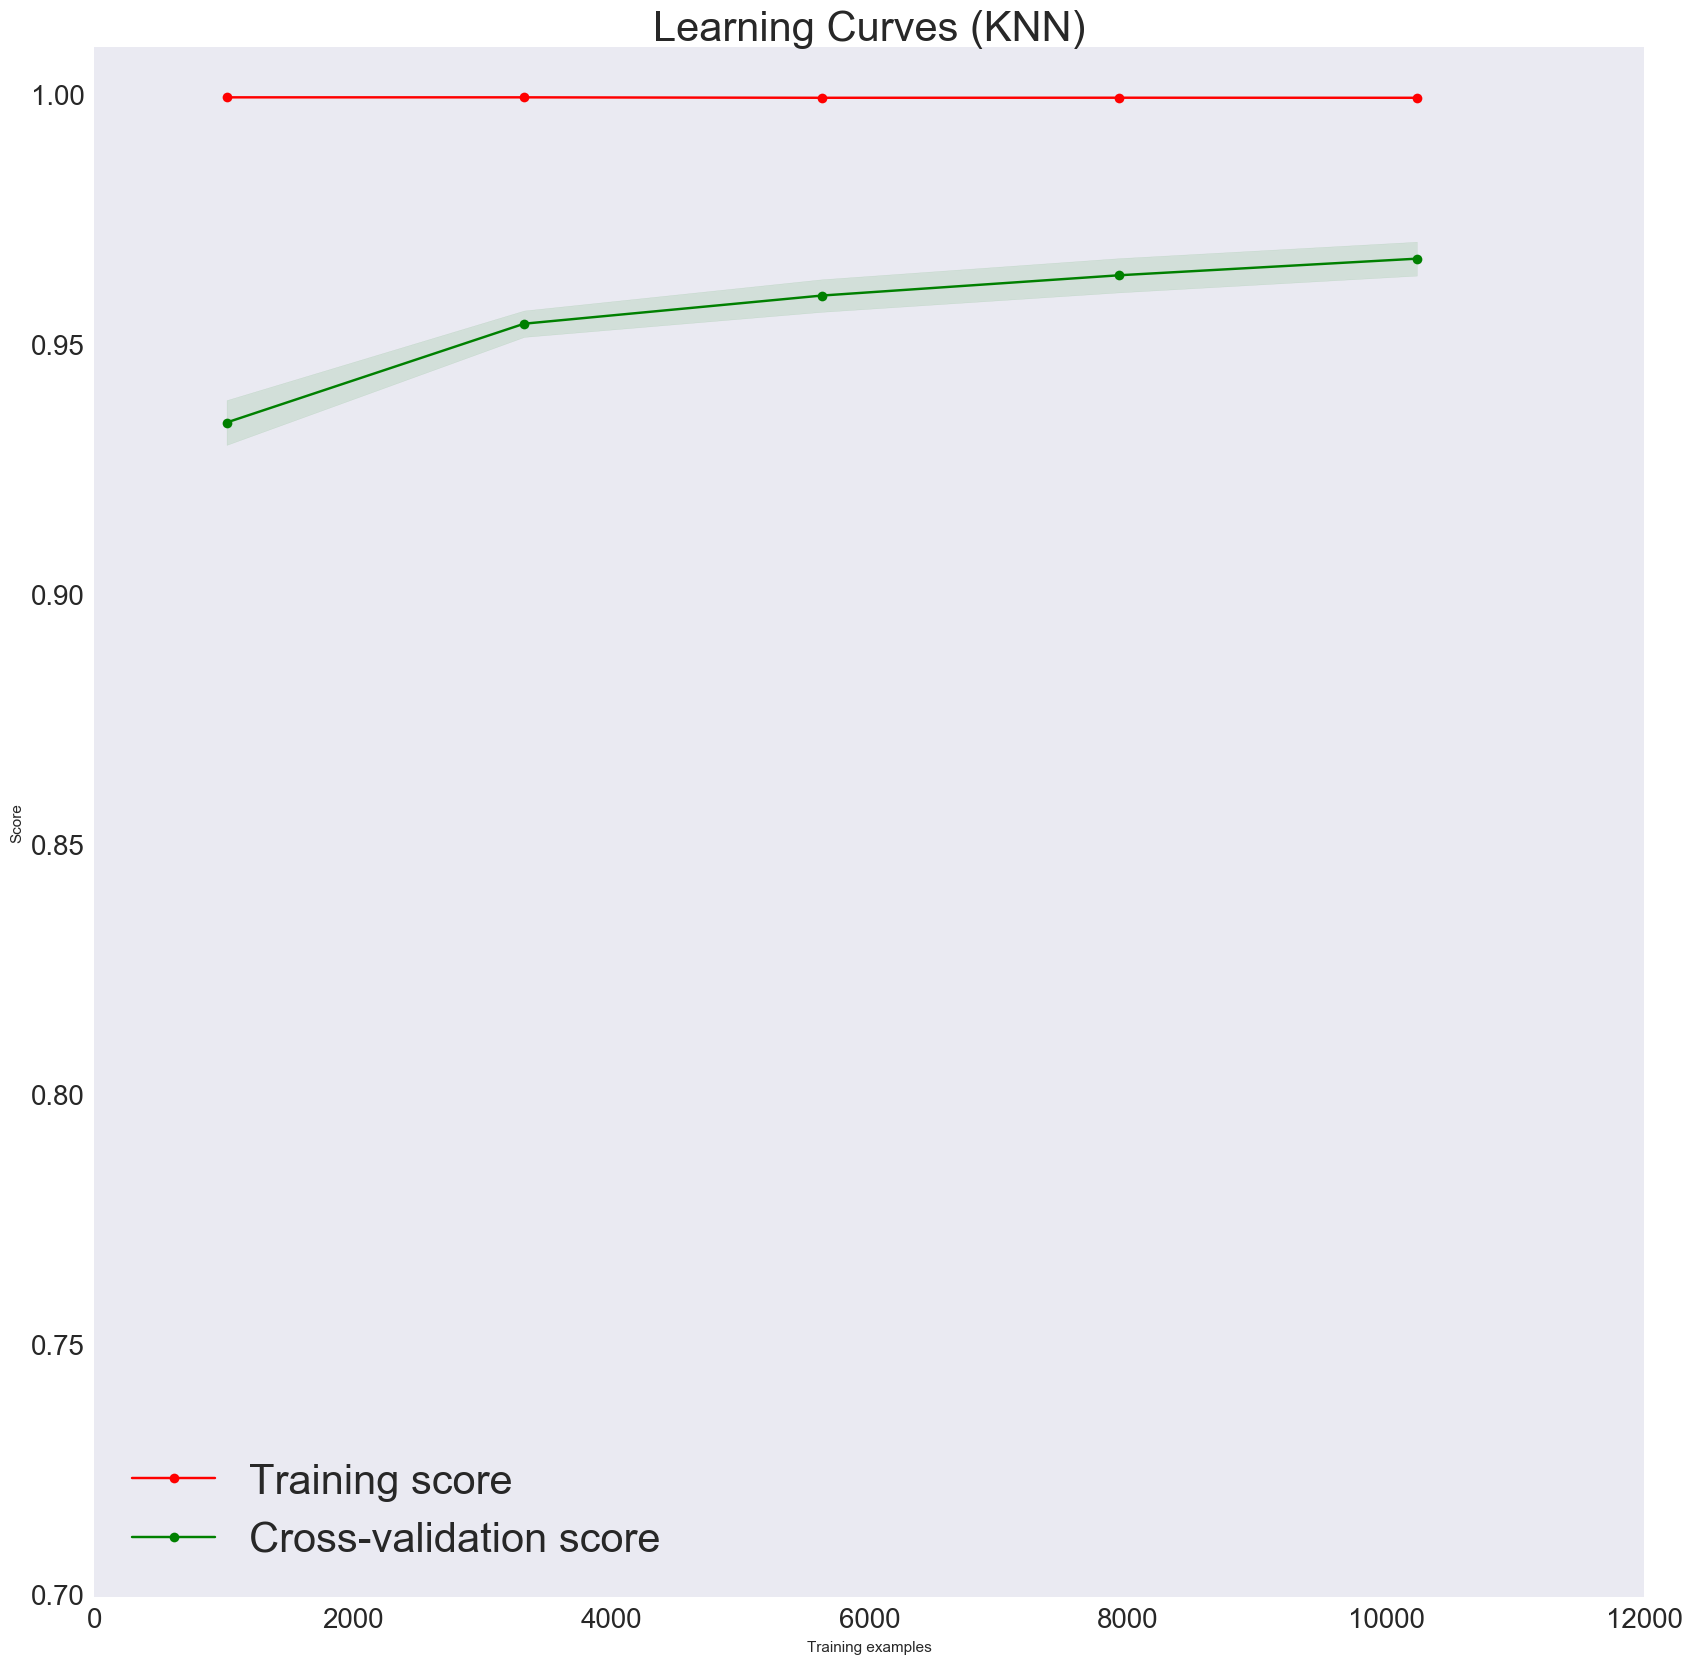

In [21]:
#KNN algorithms
title = "Learning Curves (KNN)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = knn(n_neighbors=10, weights = 'distance')
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

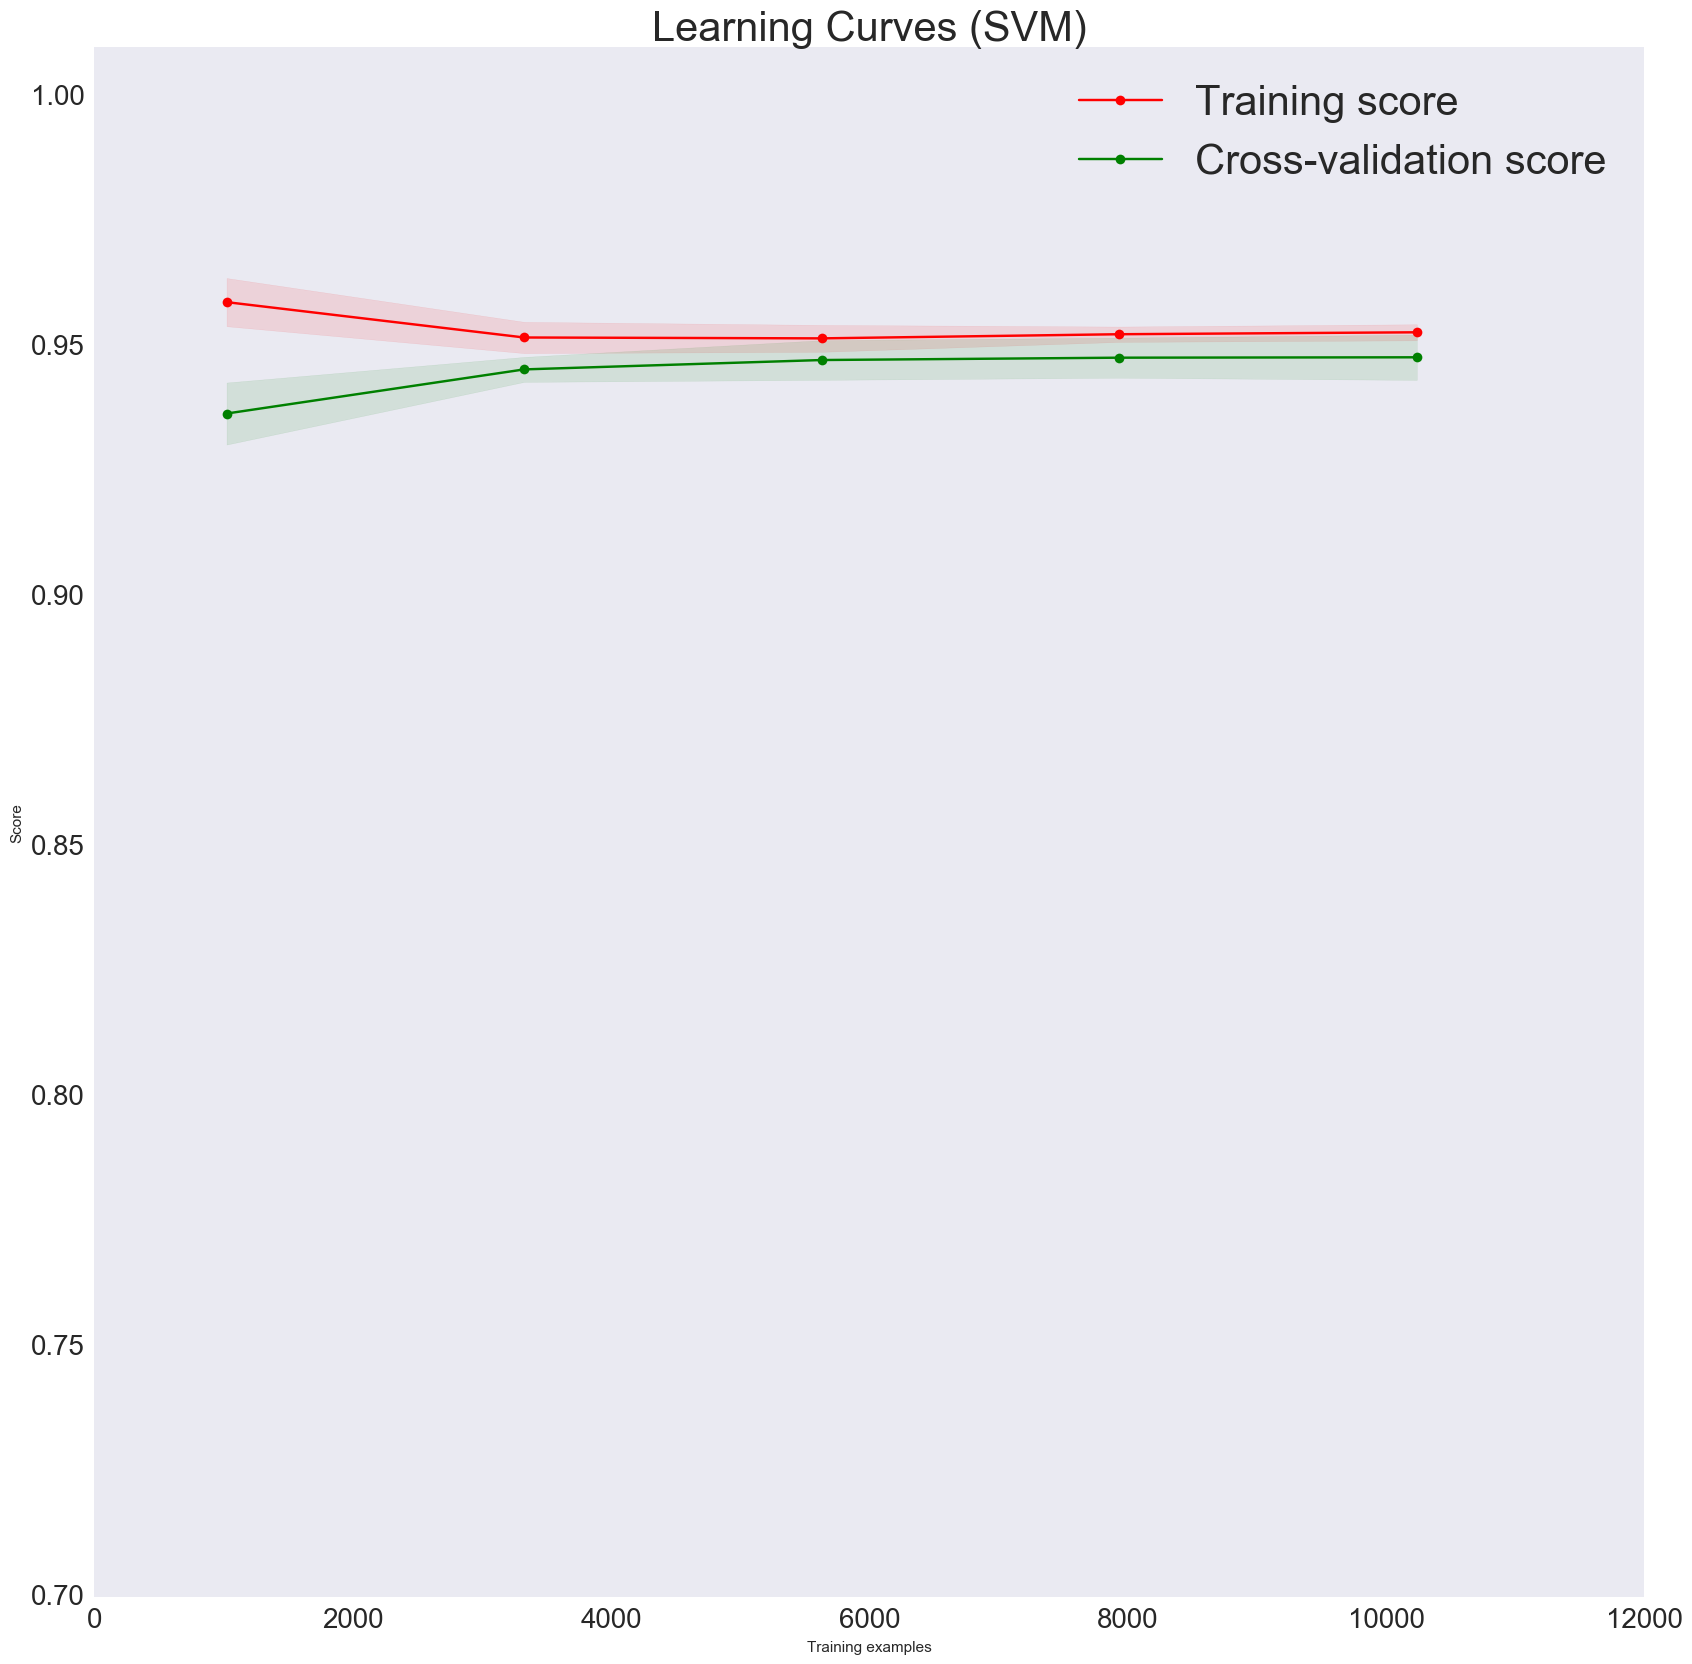

In [22]:
#SVM algorithms
title = "Learning Curves (SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = svm.SVC(C = 1000, kernel = 'poly')
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

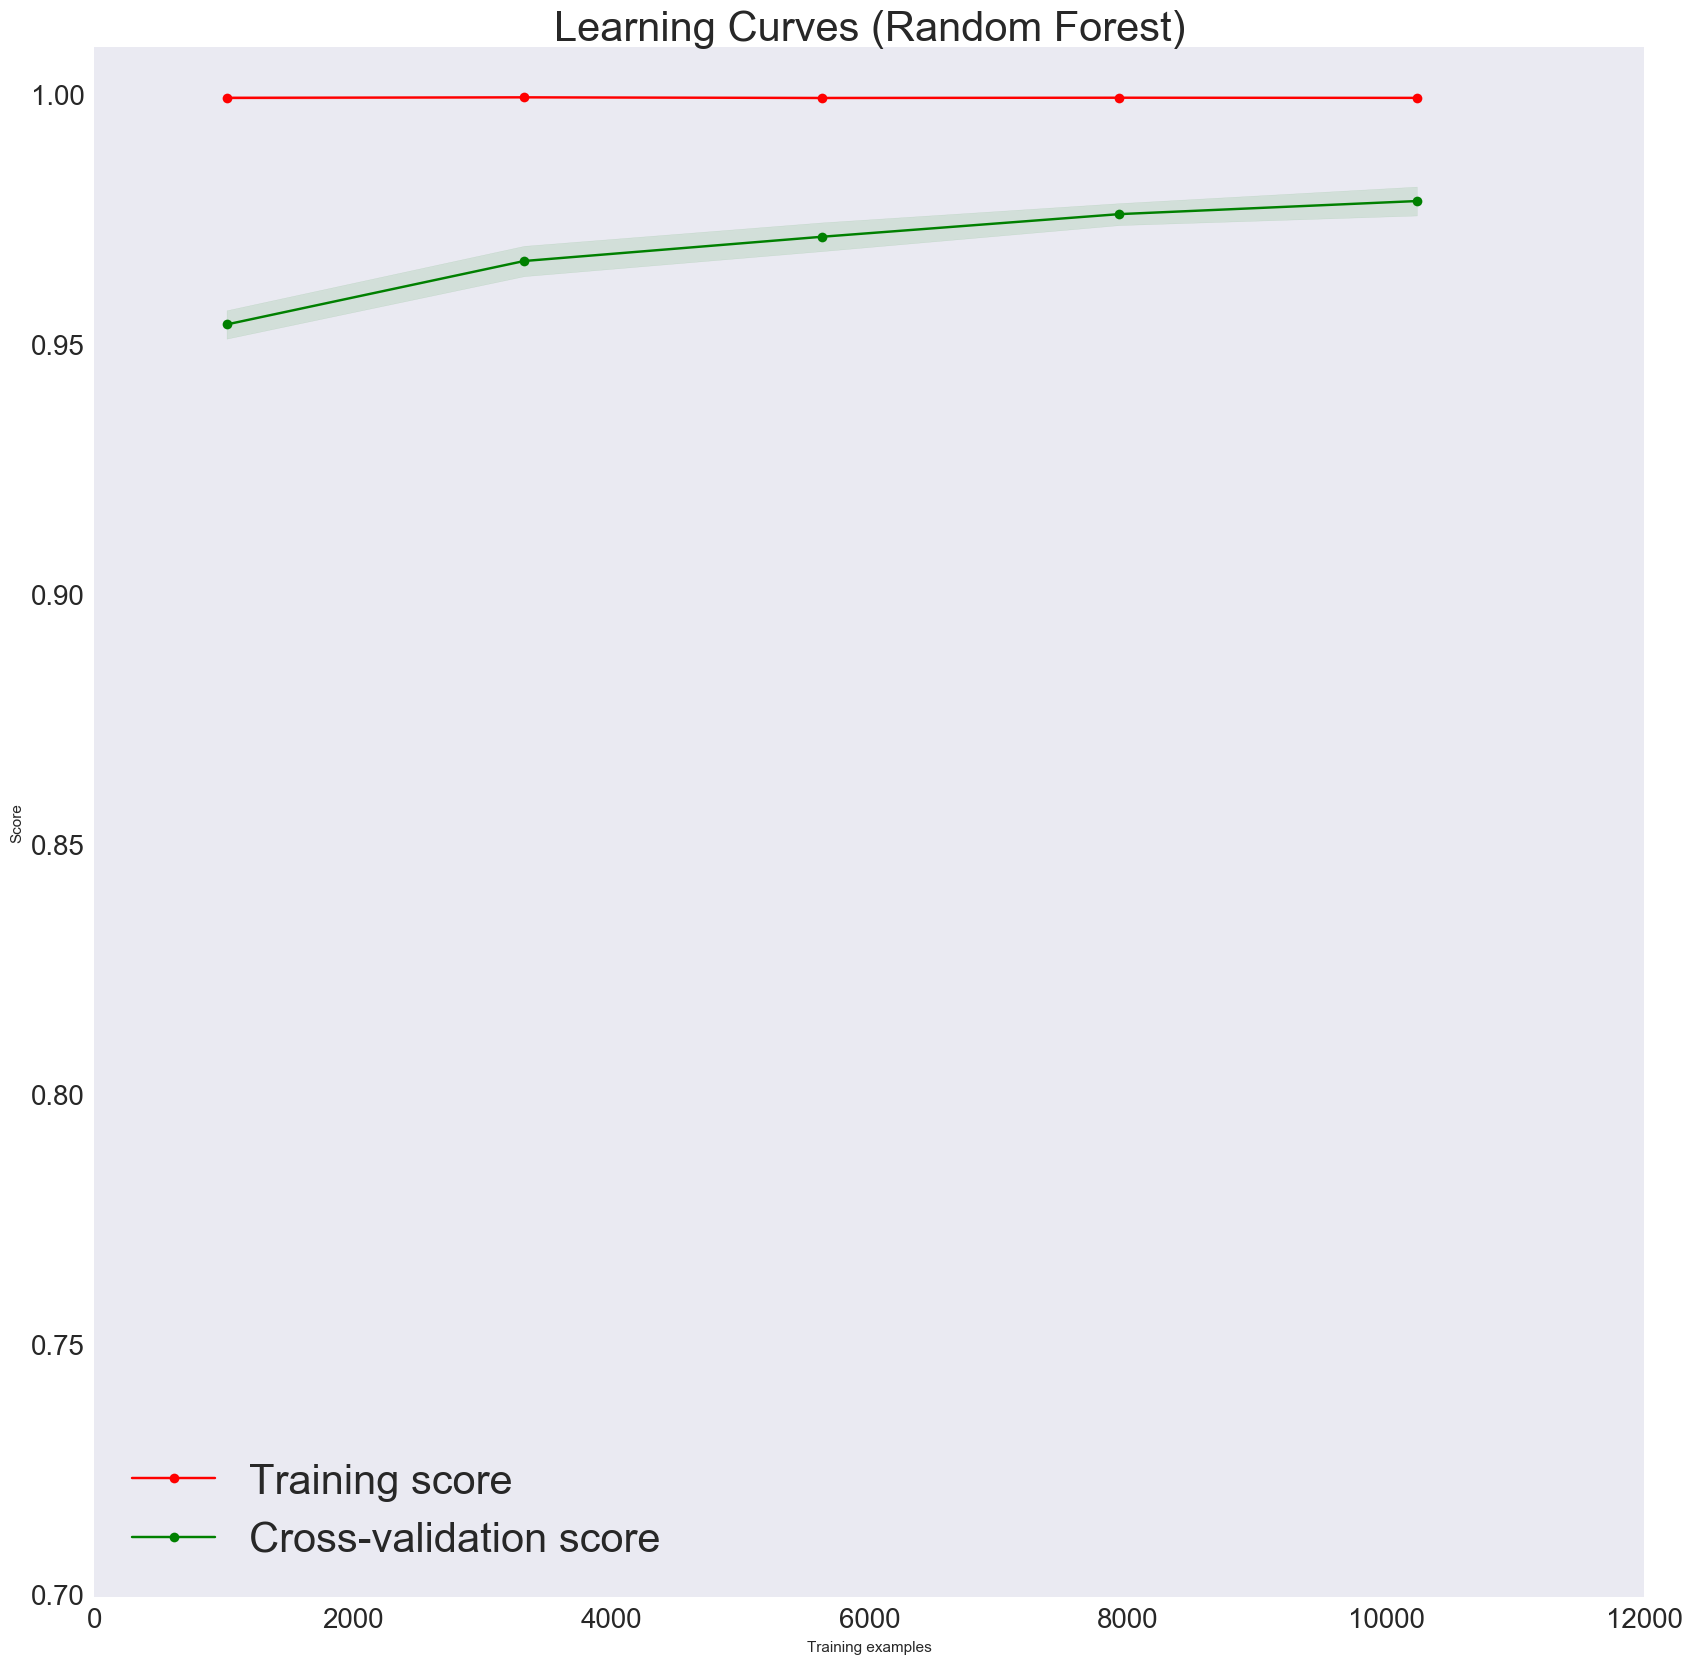

In [23]:
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(criterion =  'gini', max_depth =  30, n_estimators =  100)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

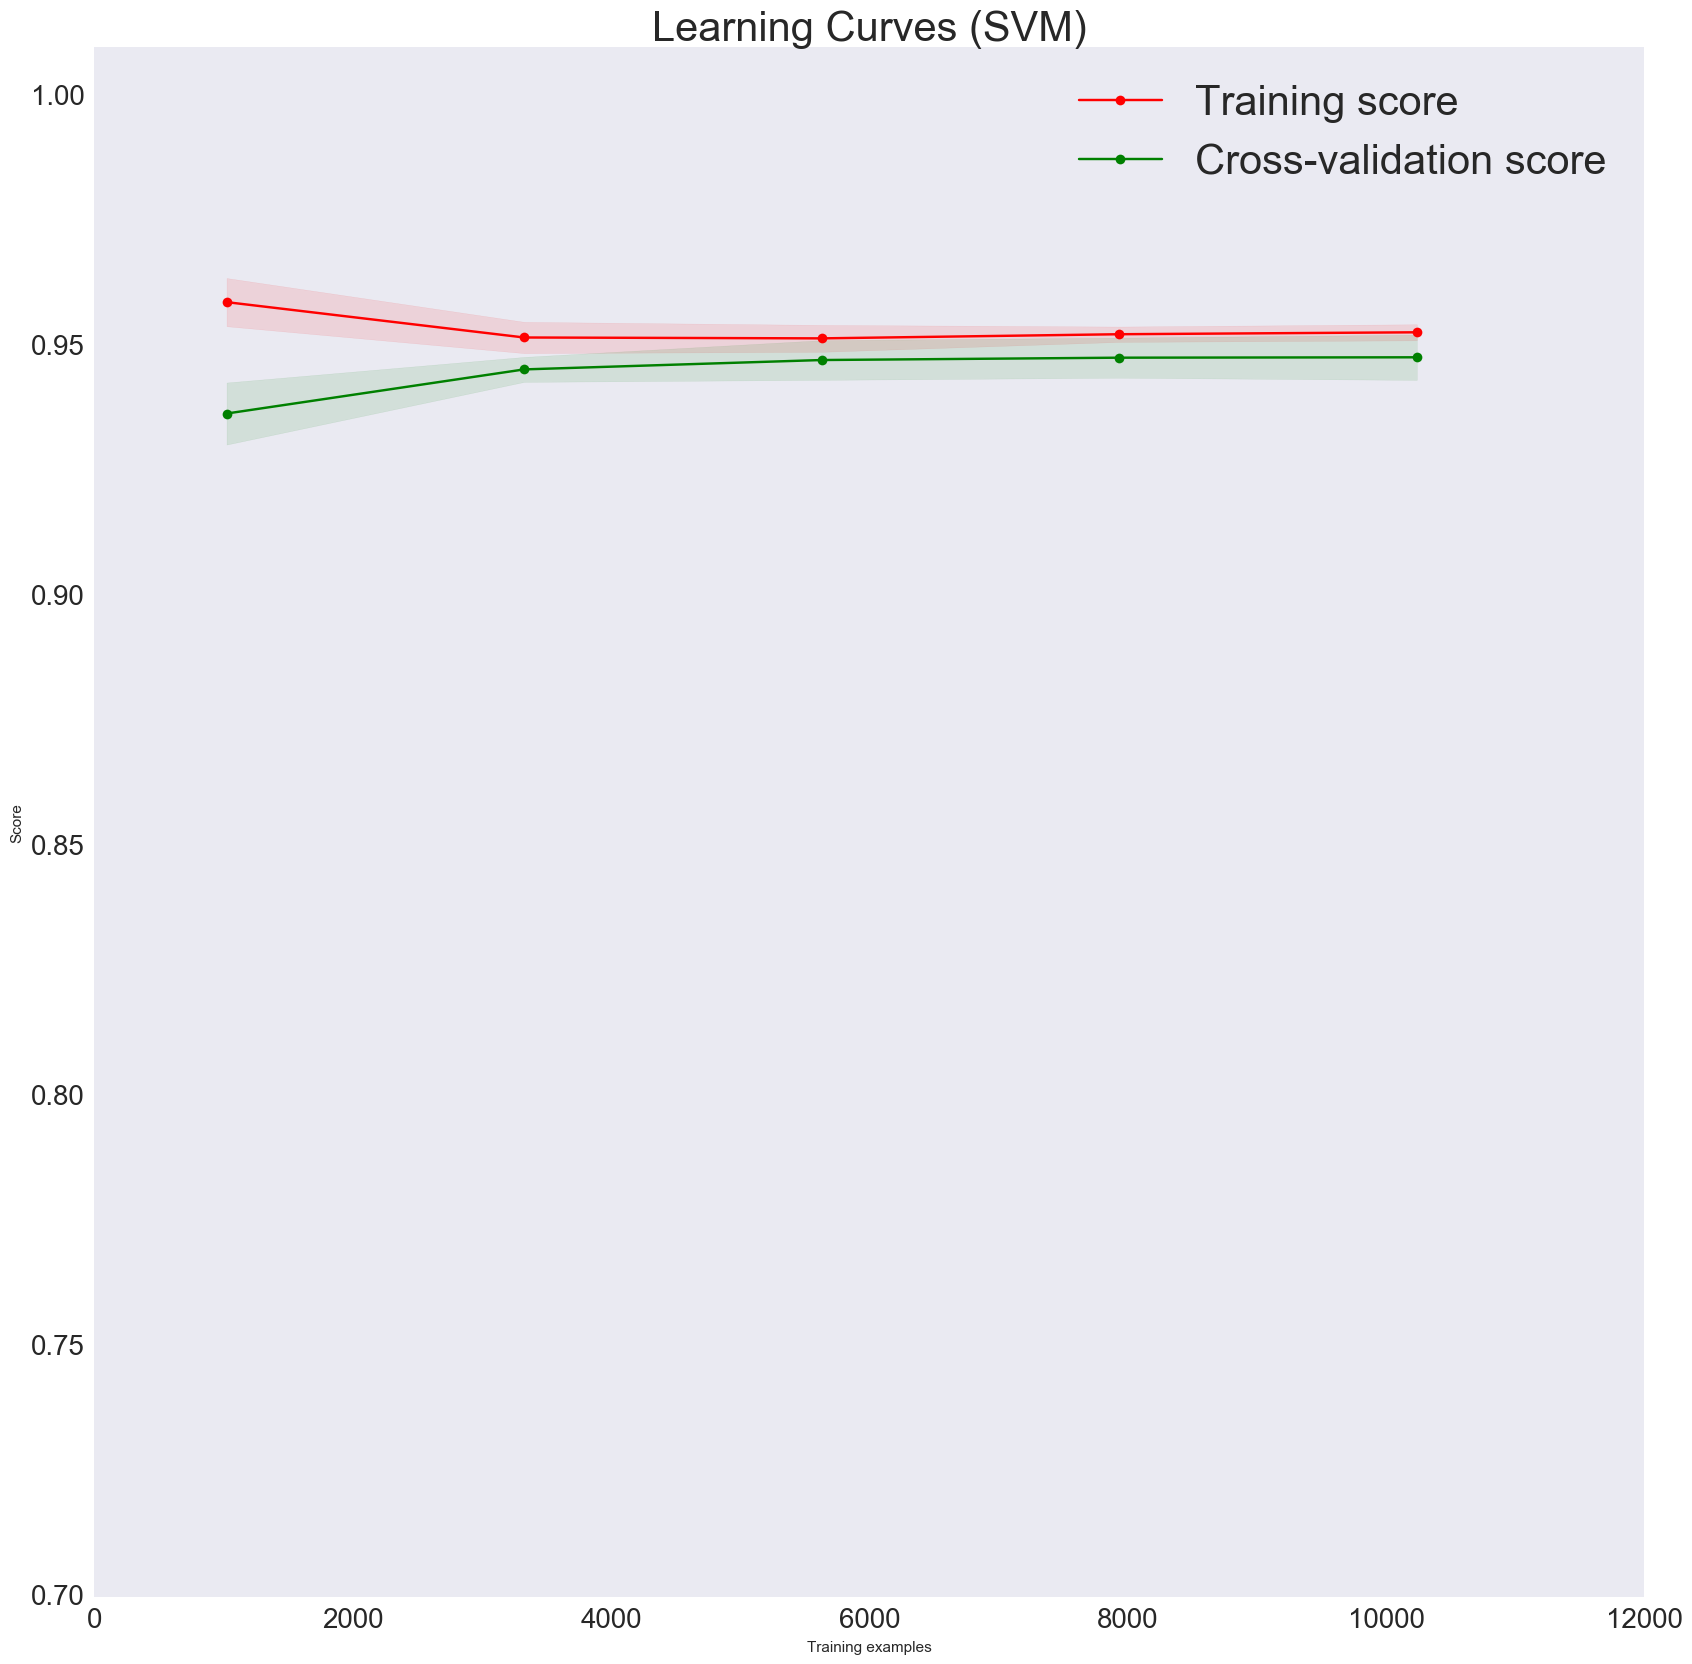

In [24]:
#SVM algorithms
title = "Learning Curves (SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = svm.SVC(C = 1000, kernel = 'poly')
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()


In [25]:
#---------------model ensembling----------------------------
#create 4 models and fit the ensemble model
clf1 = linear_model.LogisticRegression(C = 100, penalty = 'l1')
clf2 = RandomForestClassifier(criterion = 'gini', max_depth= 25, n_estimators= 80)
clf3 = svm.SVC(C = 1000, kernel =  'poly')
clf4 = knn(n_neighbors= 10, weights= 'distance')
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3), ('knn', clf4)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Logistic Regression', 'Random Forest', 'SVM', 'KNN' ,'Ensemble']):
     scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
     
linear_result = clf1.fit(X_train, y_train).predict(X_test)
KNN_result = clf2.fit(X_train, y_train).predict(X_test)
SVM_result = clf3.fit(X_train, y_train).predict(X_test)
RF_result = clf4.fit(X_train, y_train).predict(X_test)
ensemble_result = eclf.fit(X_train, y_train).predict(X_test)

linear_acc = accuracy_score(linear_result, y_test)
KNN_acc = accuracy_score(KNN_result, y_test)
SVM_acc = accuracy_score(SVM_result, y_test)
RF_acc = accuracy_score(RF_result, y_test)
ensemble_acc = accuracy_score(ensemble_result, y_test)

classifier_name = ['Logistic', 'KNN', 'SVM', 'Random Forest', 'Ensemble model']
acc_sum = [linear_acc, KNN_acc, SVM_acc, RF_acc, ensemble_acc]

Accuracy_summary = pd.DataFrame(
    { "Accuracy":acc_sum,
"Classification Algorithms" :classifier_name})

Accuracy_summary.head()

Accuracy: 0.89 (+/- 0.00) [Logistic Regression]
Accuracy: 0.98 (+/- 0.00) [Random Forest]
Accuracy: 0.95 (+/- 0.00) [SVM]
Accuracy: 0.97 (+/- 0.00) [KNN]
Accuracy: 0.96 (+/- 0.00) [Ensemble]


,Accuracy,Classification Algorithms
0,0.893263,Logistic
1,0.982065,KNN
2,0.949038,SVM
3,0.970472,Random Forest
4,0.963911,Ensemble model


In [26]:
Accuracy_summary.describe()

,Accuracy
count,5.000000
mean,0.951750
std,0.034805
min,0.893263
25%,0.949038
50%,0.963911
75%,0.970472
max,0.982065


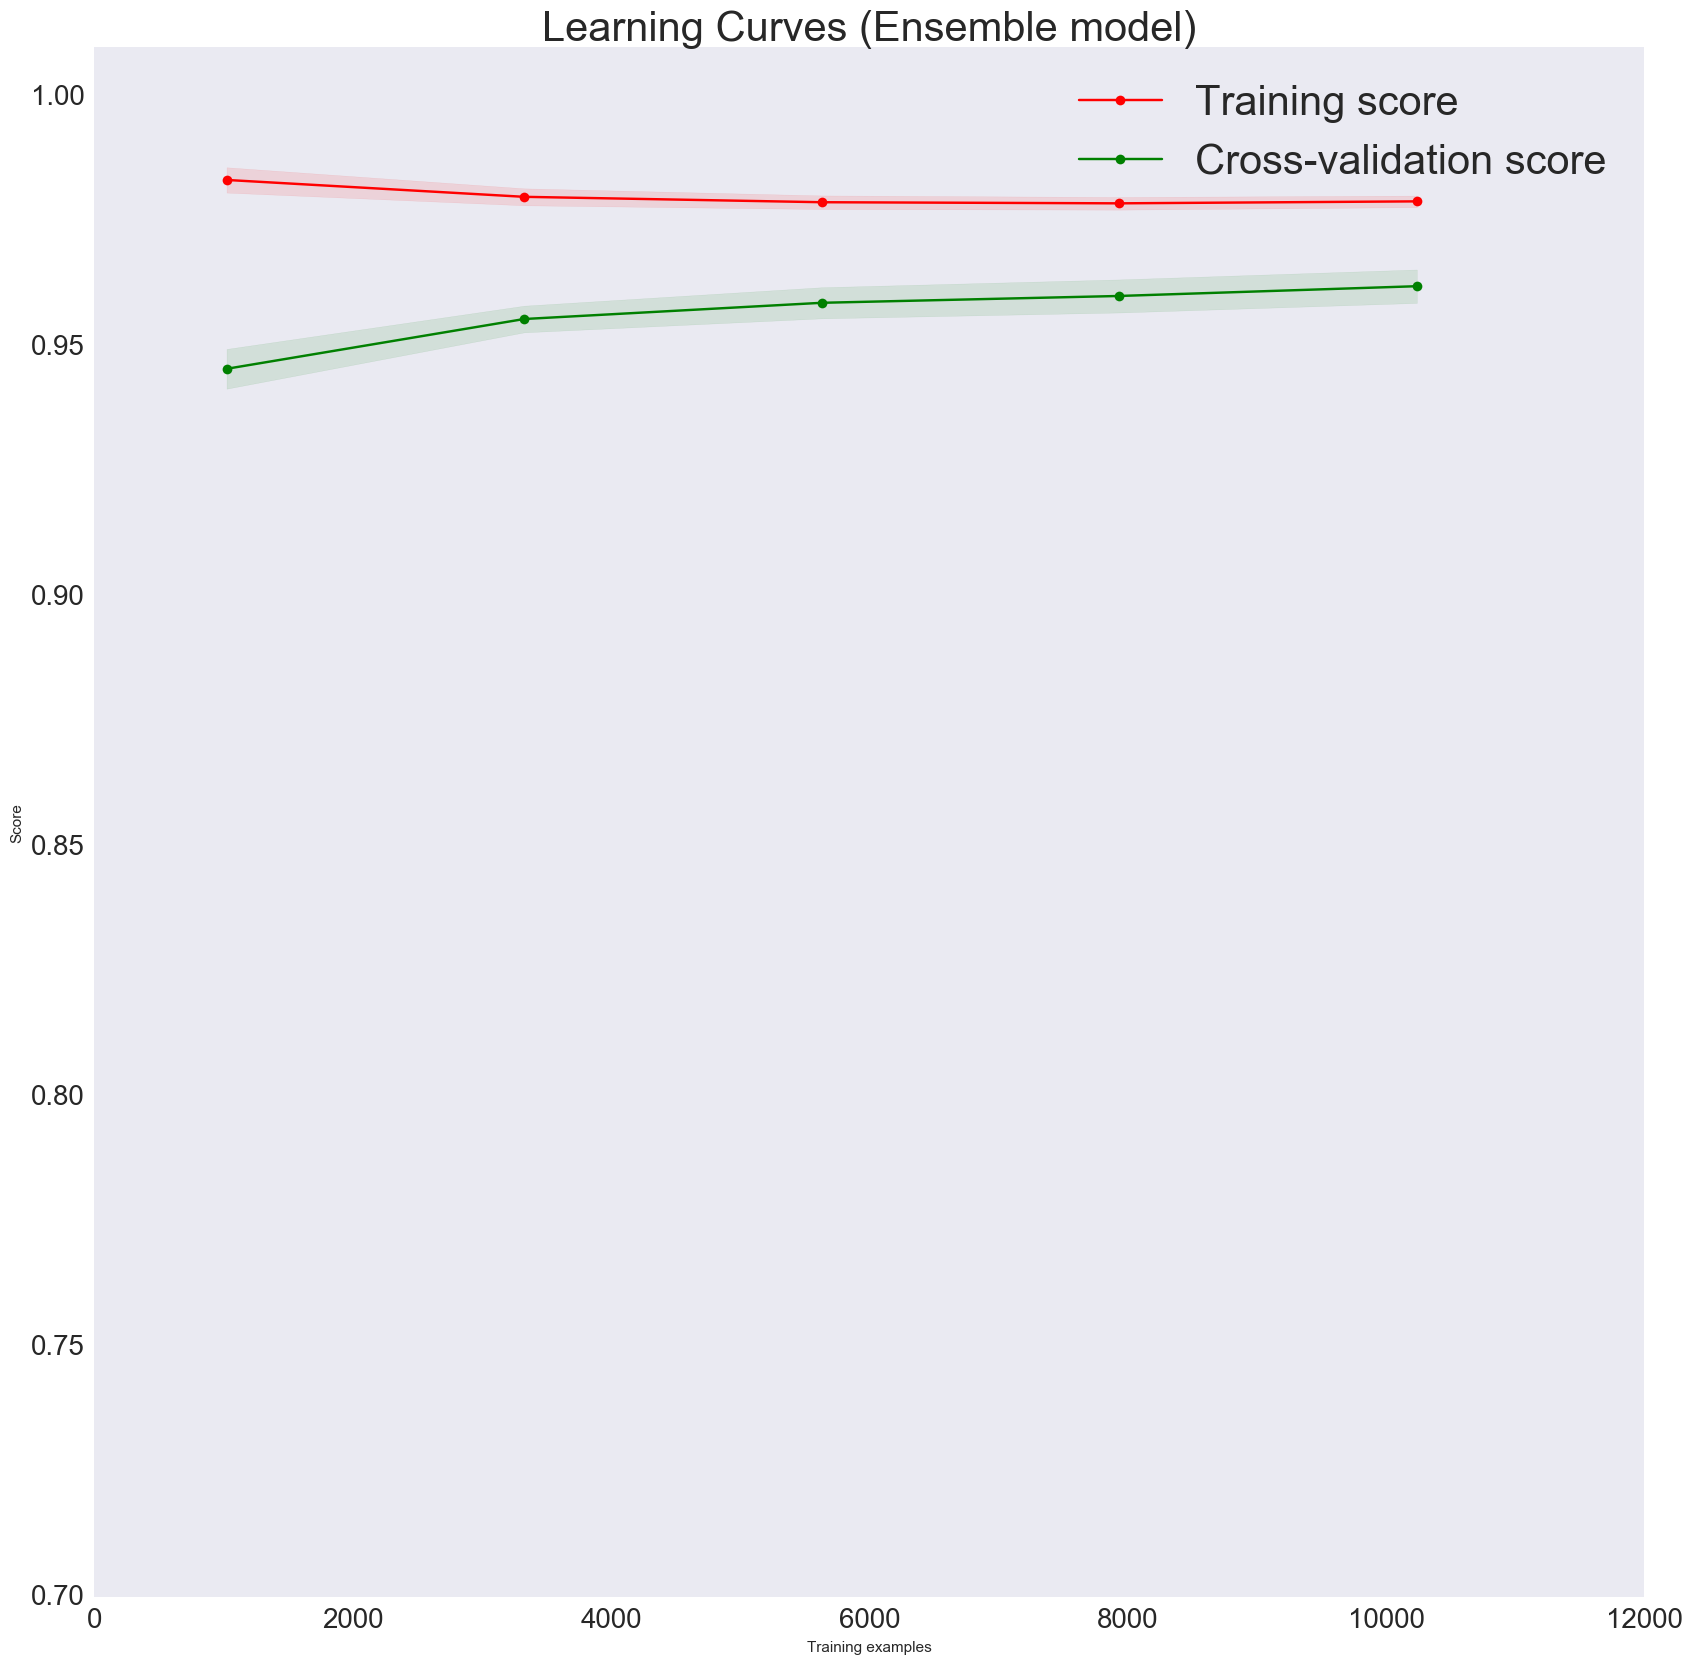

In [27]:
title = "Learning Curves (Ensemble model)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#plot the learning curve of ensemble model
estimator = eclf
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()    


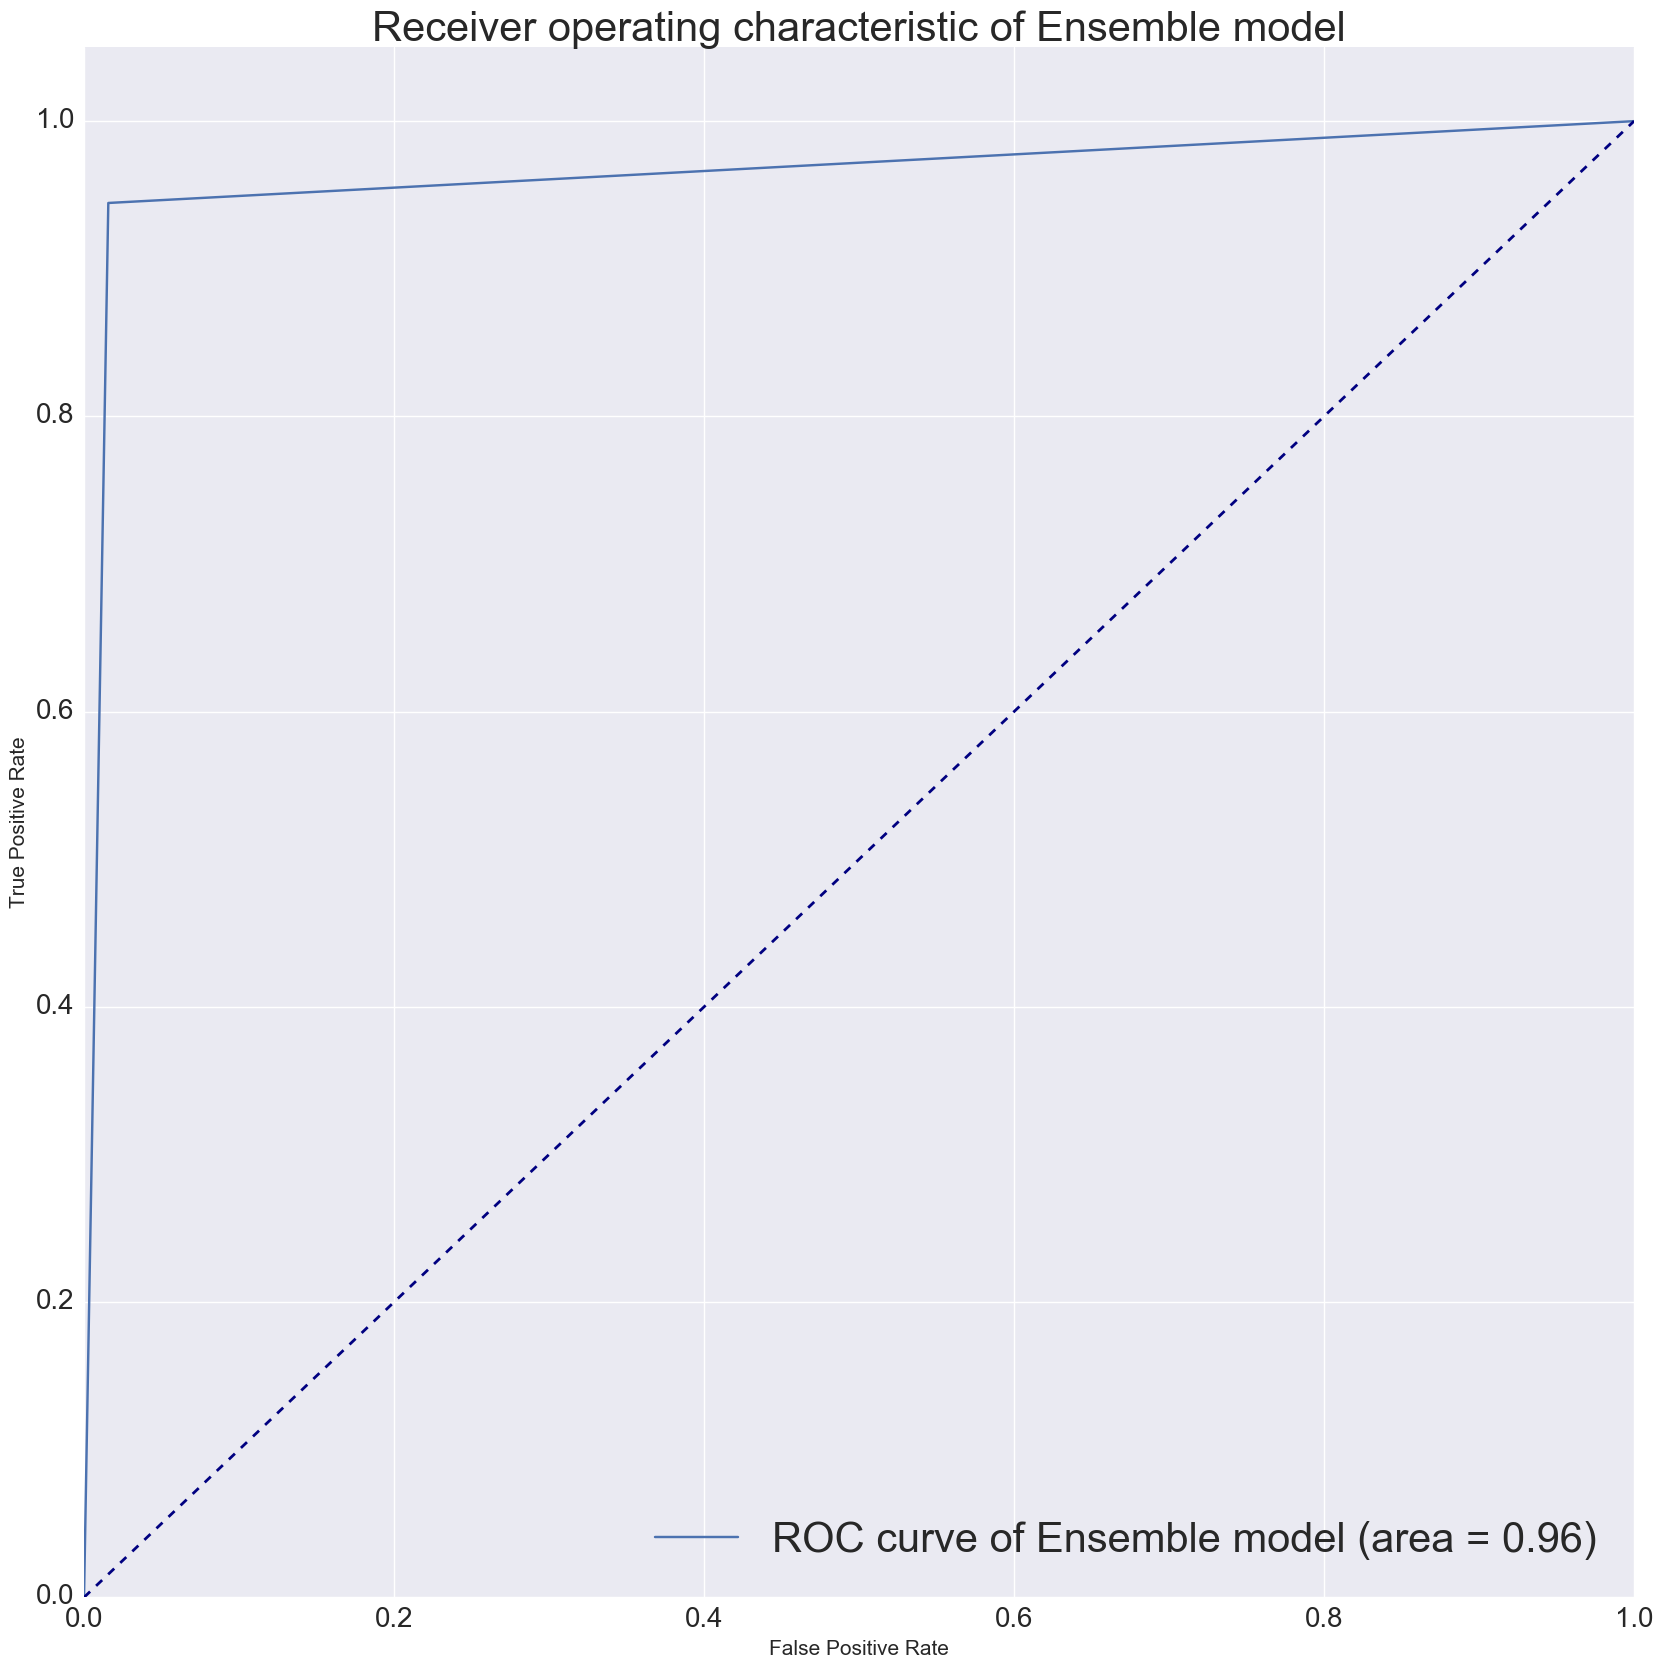

In [28]:
#plot the roc of ensemble model
y_score_eclf = eclf.fit(X_train, y_train).predict(X_test)



i = 8
fpr[i], tpr[i], _ = roc_curve(y_test, y_score_eclf)
roc_auc[i] = auc(fpr[i], tpr[i])
auc_val[i] = metrics.auc(fpr[i], tpr[i])

plt.figure(figsize=(20, 20))
lw = 2
ensemble = 'Ensemble model'
plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'
                               ''.format(ensemble, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.rc('legend', fontsize=30)    # legend fontsize
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('Receiver operating characteristic of Ensemble model', fontsize = 30)
plt.legend(loc="lower right")
plt.show()